In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Set fp16
#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

In [42]:
# Load data
data = pd.read_csv("saved_data/data.csv")

In [43]:
# Drop unnecessary columns
data = data.drop(labels=["text", "lemmatized_text", "split_text", "text_indeces", "overall"], axis=1)

In [4]:
def preprocessor_model(seq_length = 128):
    preprocessor = hub.load(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

    # Tokenize batches of text inputs.
    text_inputs = [layers.Input(shape=(), dtype=tf.string)]
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]

    # Pack input sequences for the Transformer encoder.
    bert_pack_inputs = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length))
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    
    return Model(inputs=text_inputs, outputs=encoder_inputs) 

In [5]:
# Load preprocessor model
preprocessor = preprocessor_model()
preprocessor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, None, None)        0         
                                                                 
 keras_layer_1 (KerasLayer)  {'input_word_ids': (None  0         
                             , 128),                             
                              'input_mask': (None, 12            
                             8),                                 
                              'input_type_ids': (None            
                             , 128)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Preprocess data
preprocessed_data = preprocessor.predict(data["text_cleaned"])

29584/29584 [==============================] - 3536s 120ms/step


In [35]:
preprocessed_data_lists = {}
preprocessed_data_lists["input_word_ids"] = preprocessed_data["input_word_ids"].tolist()
preprocessed_data_lists["input_mask"] = preprocessed_data["input_mask"].tolist()
preprocessed_data_lists["input_type_ids"] = preprocessed_data["input_type_ids"].tolist()

In [77]:
# Append processed data to the dataframe
df_dictionary = pd.DataFrame.from_dict(preprocessed_data_lists)
data = pd.concat([data, df_dictionary], axis=1)
data

,text_cleaned,y,input_word_ids,input_mask,input_type_ids
0,sucks It sucks barely picks up anything defini...,0.2,"[101, 19237, 2009, 19237, 4510, 11214, 2039, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Defective Well to write short one it blew fus...,0.2,"[101, 28829, 2092, 2000, 4339, 2460, 2028, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Looks cool Probably works have absolutely no m...,0.6,"[101, 3504, 4658, 2763, 2573, 2031, 7078, 2053...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Five Stars it ok it does it job,1.0,"[101, 2274, 3340, 2009, 7929, 2009, 2515, 2009...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,this have been great for my Ford transit conne...,1.0,"[101, 2023, 2031, 2042, 2307, 2005, 2026, 4811...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
946654,works great just what needed to see what amps ...,1.0,"[101, 2573, 2307, 2074, 2054, 2734, 2000, 2156...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
946655,Five Stars Really good just need to be calibra...,1.0,"[101, 2274, 3340, 2428, 2204, 2074, 2342, 2000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
946656,Nice product at bargain price Last year bought...,1.0,"[101, 3835, 4031, 2012, 17113, 3976, 2197, 209...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
946657,Digital meter This is great product Well manu...,1.0,"[101, 3617, 8316, 2023, 2003, 2307, 4031, 2092...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
file_path = "saved_data/bert_data.json"

In [170]:
# Save data to file
data.to_json(file_path, orient="records", lines=True)

In [4]:
# Load data from file
data = pd.read_json(file_path, lines=True)
data.head()

,text_cleaned,y,input_word_ids,input_mask,input_type_ids
0,sucks It sucks barely picks up anything defini...,0.2,"[101, 19237, 2009, 19237, 4510, 11214, 2039, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Defective Well to write short one it blew fus...,0.2,"[101, 28829, 2092, 2000, 4339, 2460, 2028, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Looks cool Probably works have absolutely no m...,0.6,"[101, 3504, 4658, 2763, 2573, 2031, 7078, 2053...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Five Stars it ok it does it job,1.0,"[101, 2274, 3340, 2009, 7929, 2009, 2515, 2009...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,this have been great for my Ford transit conne...,1.0,"[101, 2023, 2031, 2042, 2307, 2005, 2026, 4811...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
data_sampled = data.sample(n=100000, random_state=1)

In [33]:
# Train/dev/test split
X_train, X_test, y_train, y_test = train_test_split(
    data_sampled[["input_word_ids", "input_mask", "input_type_ids"]],
    data_sampled["y"].tolist(), 
    test_size=0.1,
    random_state=1
)

X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [44]:
# Define the bert model
def bert_regression_model(seq_length = 128, drop_out=0.2):
    # Use BERT encoder to produce a representation of the input sequence
    encoder_inputs = dict(
        input_word_ids=layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_word_ids"),
        input_mask=layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_mask"),
        input_type_ids=layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_type_ids")
    )
    
    encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
        trainable=True,
        name="BERT"
    )
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]
    
    # Add a regressor to predict customer feedback
    X = layers.Dense(32, activation="relu")(pooled_output)
    prediction = layers.Dense(1, activation='sigmoid', name="output_regression")(X)
    
    return Model(inputs=encoder_inputs, outputs=prediction) 

In [45]:
# Load bert model
bert_model = bert_regression_model()
bert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 BERT (KerasLayer)              {'sequence_output':  109482241   ['input_mask[0][0]',             
                                 (None, 128, 768),                'input_type_ids[0][0]',   

In [46]:
# Compile the model
bert_model.compile(optimizer='adam', loss="mean_squared_error", metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError()])

In [15]:
class BERTDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=16):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.__convert_to_dict(batch_x), batch_y
    
    def __convert_to_dict(self, dataset):
        return dict(
            input_word_ids=np.array(dataset["input_word_ids"].values.tolist()),
            input_mask=np.array(dataset["input_mask"].values.tolist()),
            input_type_ids=np.array(dataset["input_type_ids"].values.tolist())
        )


In [ ]:
train_gen = BERTDataGenerator(X_train, np.asarray(y_train))
dev_gen = BERTDataGenerator(X_dev, np.asarray(y_dev))
test_gen = BERTDataGenerator(X_test, np.asarray(y_test))

history = bert_model.fit(
    train_gen,
    epochs=3,
    validation_data=dev_gen
)

In [19]:
def convert_to_dict(dataset):
    return dict(
        input_word_ids=np.array(dataset["input_word_ids"].values.tolist()),
        input_mask=np.array(dataset["input_mask"].values.tolist()),
        input_type_ids=np.array(dataset["input_type_ids"].values.tolist())
    )

In [47]:
history = bert_model.fit(
    x=convert_to_dict(X_train),
    y=np.asarray(y_train),
    batch_size=16,
    epochs=3,
    validation_data=(
        convert_to_dict(X_dev),
        np.asarray(y_dev)
    )
)

Epoch 1/3
5625/5625 [==============================] - 3298s 583ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - root_mean_squared_error: 0.2237 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_root_mean_squared_error: 0.2254
Epoch 2/3
5625/5625 [==============================] - 2436s 433ms/step - loss: 0.0493 - mean_squared_error: 0.0493 - root_mean_squared_error: 0.2221 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_root_mean_squared_error: 0.2254
Epoch 3/3
5625/5625 [==============================] - 2870s 510ms/step - loss: 0.0493 - mean_squared_error: 0.0493 - root_mean_squared_error: 0.2221 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_root_mean_squared_error: 0.2254


In [35]:
# Function to summarize history for loss
def summarize_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

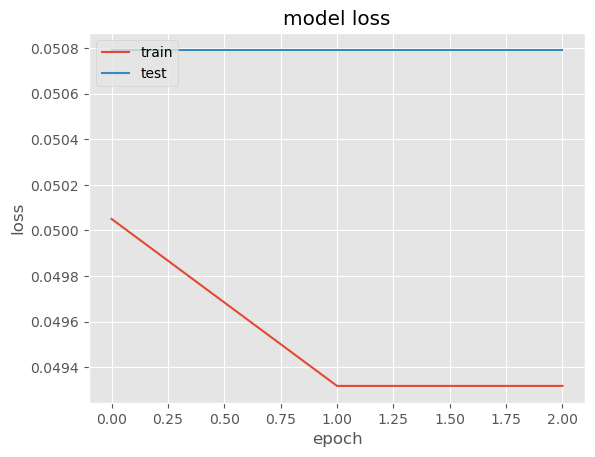

In [48]:
summarize_history(history)

In [39]:
# Function to make predictions from test set and calculate mse, rmse, r2
def evaluate_test(model, X_test, y_test):
    prediction = model.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction)
    print(f"mse = {mse}")
    print(f"rmse = {rmse}")
    print(f"r2 = {r2}")

In [49]:
evaluate_test(bert_model, convert_to_dict(X_test), np.asarray(y_test))

157/157 [==============================] - 40s 252ms/step
mse = 0.048215999999999995
rmse = 0.2195814199790137
r2 = -0.2365512485146306


In [41]:
# Function to plot histograms
def plot_histogram(model, X_test, y_test):
    prediction = model.predict(X_test)
    prediction = np.reshape(prediction, (prediction.shape[0],))
    df = pd.DataFrame()
    df["prediction"] = prediction * 5
    df["target"] = y_test * 5
    target_df = df.groupby(by="target")
    plt.style.use('ggplot')
    plt.title('Histogram of predicted ratings')
    for key in target_df.groups.keys():
        plt.hist(target_df.get_group(key)['prediction'], bins=30, edgecolor='black', alpha=0.5, density=True)
    plt.legend(list(range(1,6)))
    plt.show()

157/157 [==============================] - 47s 299ms/step


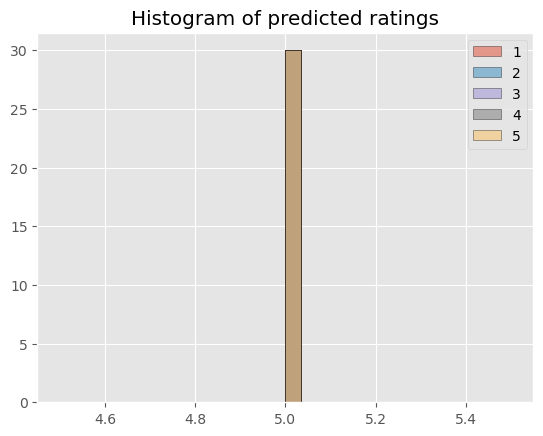

In [50]:
plot_histogram(bert_model, convert_to_dict(X_test), np.asarray(y_test))